#### The link for this artilce is "https://www.analyticsvidhya.com/blog/2018/05/essentials-of-deep-learning-trudging-into-unsupervised-deep-learning/"  The data set for this will be here ("https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-digits/") 

In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
import keras
import sklearn
import re


from time import time
from scipy.misc import imread


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
#setting the seed

seed = 123
rng = np.random.RandomState(seed)

In [3]:
#seeting the root directory and data directory
#root_dir = os.path.abspath('.')
#data_dir = os.path.join()

In [3]:
#changing the working directory

os.chdir("E:\\AV\\case study\\mnist - unsupervised deep learning")

In [4]:
train = pd.read_csv("train\\train\\train.csv")
test = pd.read_csv("Test.csv")

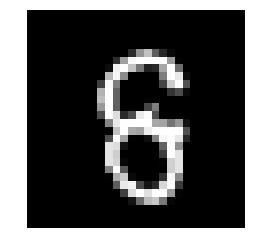

In [5]:
#plotting of an  image

img_name = rng.choice(train.filename)

filepath = os.path.join('E:\\AV\\case study\\mnist - unsupervised deep learning\\Train\\Train\\Images','train',img_name)
img = imread(filepath,flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()


In [6]:
#we have to store all the images in a numpy array to create train and test data

temp = []
for img_name in train.filename:
    image_path = os.path.join('E:\\AV\\case study\\mnist - unsupervised deep learning\\Train\\Train\\Images','train',img_name)
    img = imread(image_path,flatten=True)
    img = img.astype('float32')
    temp.append(img)
    


In [7]:
x = np.array(temp)

In [8]:
x.shape

(49000, 28, 28)

In [9]:
train_x = np.stack(temp)

In [10]:
train_x /= 255.0

In [11]:
train_x = train_x.reshape(-1,784).astype('float32')

In [12]:
train_x.shape

(49000, 784)

In [13]:
#simillarly for test

temp = []
for img_name in test.filename:
    image_path = os.path.join('E:\\AV\\case study\\mnist - unsupervised deep learning\\Train\\Train\\Images','test',img_name)
    img = imread(image_path,flatten=True)
    img = img.astype('float32')
    temp.append(img)

test_x = np.stack(temp)
test_x /= 255.0
test_x = test_x.reshape(-1,784).astype('float32')

In [14]:
train_y = train.label.values

In [15]:
int(train_x.shape[0]*0.7)

34300

In [16]:
train_y.shape

(49000,)

In [17]:
#split the train into validation and train

split = int(train_x.shape[0]*0.7)

train_x,val_x = train_x[:split],train_x[split:]
train_y,val_y = train_y[:split],train_y[split:]




In [18]:
#now implementing a simple k-means clustering on train data with 10 clusters
from sklearn.cluster import KMeans 
from sklearn.metrics import accuracy_score,normalized_mutual_info_score


In [19]:
km_model = KMeans(n_clusters=10,n_jobs=-1,n_init =20)

In [48]:
km_model.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [49]:
pred = km_model.predict(val_x)

We will use Normalized Mutual Information (NMI) score to evaluate our model.
Mutual information is a symmetric measure for the degree of dependency between the clustering and the manual classification. It is based on the notion of cluster purity pi, which measures the quality of a single cluster Ci, the largest number of objects in cluster Ci which Ci has in common with a manual class Mj, having compared Ci to all manual classes in M. Because NMI is normalized, we can use it to compare clusterings with different numbers of clusters.

The formula for NMI is:


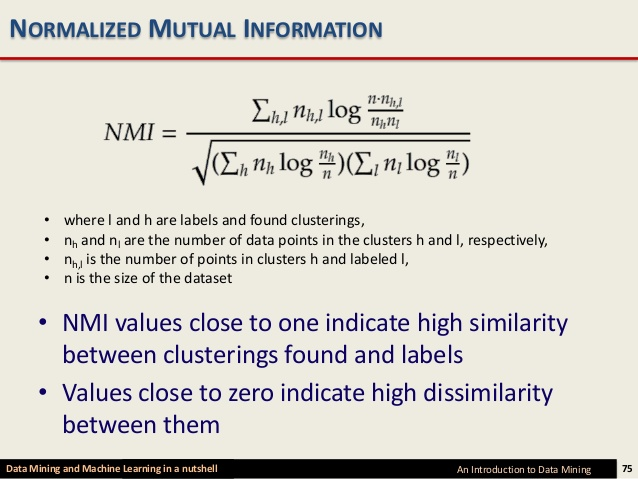




In [55]:
pred[1:10]

array([9, 3, 5, 5, 5, 5, 6, 1, 1])

In [56]:
val_y[1:10]

array([1, 6, 8, 3, 8, 8, 9, 3, 8], dtype=int64)

In [57]:
accuracy_score(val_y,pred)

0.073537414965986397

In [50]:
normalized_mutual_info_score(val_y, pred)

0.4984843700756692

Now instead of directly applying K-Means on the problem, we will first use an autoencoder to decrease the dimensionality of the data and extract useful information. This will then pass on the information to the K-Means algorithm

In [36]:
from keras import callbacks
from keras.models import Model,Sequential
from keras.optimizers import sgd
from keras.layers import Dense,Input,Dropout
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

In [23]:
# implementing auto encoder

#thin is input plaeholder
input_img = Input(shape=(784,))
corrupt_img = Dropout(0.5)(input_img)

In [24]:
#encoded

encoded = Dense(500,activation='relu')(corrupt_img)
encoded = Dense(500,activation='relu')(encoded)
encoded = Dense(2000,activation='relu')(encoded)
encoded = Dense(10,activation='sigmoid')(encoded)

#decoded

decoded = Dense(2000,activation='relu')(encoded)
decoded = Dense(500,activation='relu')(decoded)
decoded = Dense(500,activation='relu')(decoded)
decoded = Dense(784)(decoded)

#model to map an input to its reconstruction

autoencoder = Model(input_img,decoded)

In [25]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20010     
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              22000     
__________

In [26]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [27]:
autoencoder.compile(optimizer='adam',loss='mse')

In [32]:
#Now let us train our autoencoder model.
train_history = autoencoder.fit(train_x, train_x, epochs=100, batch_size=2048, validation_data=(val_x, val_x))

Train on 34300 samples, validate on 14700 samples
Epoch 1/50
34300/34300 [==============================] - 33s - loss: 0.0209 - val_loss: 0.0201
Epoch 2/50
34300/34300 [==============================] - 32s - loss: 0.0208 - val_loss: 0.0202
Epoch 3/50
34300/34300 [==============================] - 32s - loss: 0.0207 - val_loss: 0.0200
Epoch 4/50
34300/34300 [==============================] - 32s - loss: 0.0206 - val_loss: 0.0197
Epoch 5/50
34300/34300 [==============================] - 32s - loss: 0.0204 - val_loss: 0.0196
Epoch 6/50
34300/34300 [==============================] - 32s - loss: 0.0203 - val_loss: 0.0194
Epoch 7/50
34300/34300 [==============================] - 32s - loss: 0.0202 - val_loss: 0.0194
Epoch 8/50
34300/34300 [==============================] - 32s - loss: 0.0202 - val_loss: 0.0192
Epoch 9/50
34300/34300 [==============================] - 32s - loss: 0.0201 - val_loss: 0.0192
Epoch 10/50
34300/34300 [==============================] - 32s - loss: 0.0200 - val_lo

In [33]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)

In [34]:
km_model.fit(pred_auto_train)
pred = km_model.predict(pred_auto)

In [35]:
normalized_mutual_info_score(val_y, pred)

0.69439639907143169

IF we train it with further more epochs like say 500 then this score will be close to 75%